# Nederlands-Fries

- https://leren.windesheim.nl/d2l/le/lessons/103162/topics/927096

## 1. Business Understanding

Vertaal Nederlandse zinnen naar het Fries.

## 2. Data Understanding

School heeft ons al de code aangeleverd die een tekstcorpus van het Fryske Akademy downloadt, alsook deze gegevens omgezet naar een CSV-bestand.

### 2.1. Bibliotheken importeren

In [1]:
!pip install keras_nlp
!pip install sentencepiece


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


Verberg de meldingen:

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
import os
import re
import keras
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_nlp
import matplotlib.pyplot as plt
import sentencepiece as spm

from keras import layers
from sklearn.model_selection import train_test_split

In [4]:
tf.get_logger().setLevel('INFO')

In [5]:
if "NederlandsFries.ipynb" not in os.listdir('.'):
    os.chdir("Thema 3")

### 2.2. Inlezen `dataset.csv`
De corpus bevat twee simpele kolommen, een met de Nederlandse tekst, en een met de Friese vertaling.

In [6]:
dataset_df = pd.read_csv("Data/dataset.csv")
dataset_df.info()
dataset_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   nederlands  173912 non-null  object
 1   fries       173912 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


,nederlands,fries
0,we hebben de burgemeester het advies gegeven o...,wy hawwe de boargemaster it advys jun om it ka...
1,we hebben de burgemeester het advies gegeven o...,wy hawwe de boargemaster it advys jun om it ka...
2,een plotselinge dood,in hastige dea
3,een plotselinge dood,in unferwachte dea
4,zijn plotseling overlijden,syn hastich ferstjerren


### 2.3. Inzicht zinlengte
We zien dat de teksten maximaal 60 woorden bevatten, en gemiddeld 9 woorden. Gelukkig niet te veel, zo kunnen we hem makkelijker trainen.

In [7]:
hoeveelheid_woorden_nederlands = dataset_df['nederlands'].apply(lambda txt: len(txt.split()))
print(f"Min {hoeveelheid_woorden_nederlands.min()} Max {hoeveelheid_woorden_nederlands.max()} gemiddeld {hoeveelheid_woorden_nederlands.mean()}")

Min 1 Max 59 gemiddeld 9.066044896269378


In [8]:
hoeveelheid_woorden_fries = dataset_df['fries'].apply(lambda txt: len(txt.split()))
print(f"Min {hoeveelheid_woorden_fries.min()} Max {hoeveelheid_woorden_fries.max()} gemiddeld {hoeveelheid_woorden_fries.mean()}")

Min 1 Max 60 gemiddeld 9.237137172823036


### 2.4. Inzicht woordhoeveelheid

In [9]:
len(np.unique(np.hstack(dataset_df['nederlands'].apply(lambda txt: np.array(txt.split())))))

70245

In [10]:
len(np.unique(np.hstack(dataset_df['fries'].apply(lambda txt: np.array(txt.split())))))

74319

## 3. Data Preparation

Tekst

## 3.1. Start en eindtokens toevoegen

In [11]:
START_TOKEN = "[BOS]"
END_TOKEN = "[EOS]"

def omringMetBeginEnEinde(tekst):
    return f"{START_TOKEN} {tekst} {END_TOKEN}"

dataset_df['fries'] = dataset_df['fries'].apply(omringMetBeginEnEinde)

### 3.1. Splitsen tussen traindata testdata

In [12]:
# train_dutch, test_dutch, train_frisian, test_frisian = train_test_split(
#     dataset_df['nederlands'], dataset_df['fries'],
#     test_size=0.2,
#     shuffle = True,
# )

train_pairs, test_pairs = train_test_split(
    dataset_df,
    test_size=0.2,
    shuffle = True,
)

train_pairs.head()

,nederlands,fries
101438,een vonnis bekrachtigen,[BOS] in funis befestigje [EOS]
141575,de tsjechische republiek,[BOS] de servyske republyk [EOS]
39299,de uitgavengroei weerspiegelde zo vooral de gr...,[BOS] de utjeftegroei wjerspegele sa foaral da...
18164,nu heb hij het over voetbal terwijl hij het ov...,[BOS] no hat er it oer fuotbaljen wylst er it ...
3394,britten verstaat hij het best alleen is hun ac...,[BOS] britten kin er it beste ferstean allinni...


### 3.2. Tekstvectorisatie

In [13]:
DUTCH_TOKENIZER_PATH = "Data/dutch_tokenizer.model"
FRISIAN_TOKENIZER_PATH = "Data/frisian_tokenizer.model"

# dutch_vocab_size   = 20000
# frisian_vocab_size = 20000
dutch_vocab_size   = 4000
frisian_vocab_size = 4000

dutch_maxlen   = 50
frisian_maxlen = 50

In [14]:
# train_tokenizer = not os.path.exists(DUTCH_TOKENIZER_PATH)
train_tokenizer = True

if train_tokenizer:
    with open('Data/dutch_texts.txt', 'w') as f:
        for line in dataset_df['nederlands']:
            f.write(line + "\n")

    # Train de tokenizer
    spm.SentencePieceTrainer.train(
        input='Data/dutch_texts.txt',
        model_prefix=DUTCH_TOKENIZER_PATH.split('.')[0],
        vocab_size=dutch_vocab_size,
        character_coverage=0.9995,  # Hiermee bereik je bijna volledige dekking van de tekst
        model_type='bpe'  # 'bpe' is gebruikelijk voor vertaling, maar 'unigram' werkt ook goed
    )

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Data/dutch_texts.txt
  input_format: 
  model_prefix: Data/dutch_tokenizer
  model_type: BPE
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_pr

In [15]:
dutch_tokenizer = spm.SentencePieceProcessor(model_file=DUTCH_TOKENIZER_PATH)
dutch_tokenizer.bos_id()

def dutch_text_vectorization(input_string):
    tokenized_sentence = dutch_tokenizer.encode(input_string, out_type=int)
    # Vul of snijd de tokens af tot de maximale lengte
    if len(tokenized_sentence) < dutch_maxlen:
        tokenized_sentence += [0] * (dutch_maxlen - len(tokenized_sentence))
    else:
        tokenized_sentence = tokenized_sentence[:dutch_maxlen]
    return tokenized_sentence

def decode_dutch(token_ids):
    # Filter het `END_TOKEN` als het aanwezig is
    if END_TOKEN in token_ids:
        token_ids = token_ids[:token_ids.index(END_TOKEN)]

    # Converteer token-ID's naar tekst
    decoded_sentence = dutch_tokenizer.decode(token_ids)

    return decoded_sentence

sample_text = "dit is een voorbeeldzin"
tokenized_text = dutch_tokenizer.encode(sample_text, out_type=int)
print(tokenized_text)  # Dit geeft de tokens in integer-vorm
print(decode_dutch(tokenized_text))

# dutch_text_vectorization = layers.TextVectorization(
#     max_tokens=dutch_vocab_size,
#     output_mode="int",
#     output_sequence_length=dutch_maxlen,
# )
# dutch_text_vectorization.adapt(dataset_df['nederlands'])


[272, 64, 25, 2297, 1930]
dit is een voorbeeldzin


iece=eld
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6308 size=160 all=10704 active=5150 piece=▁naar
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5539 size=180 all=11934 active=6380 piece=ist
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4935 size=200 all=13093 active=7539 piece=▁ter
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=4836 min_freq=745
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4450 size=220 all=14234 active=2118 piece=▁pl
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=4041 size=240 all=14996 active=2880 piece=▁geb
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=3475 size=260 all=16129 active=4013 piece=onder
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=3100 size=280 all=17597 active=5481 piece=▁el
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=2866 size=300 all=18399 active=6283 piece=ctie
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=2854 min_freq=646
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=2664 siz

In [17]:
# train_tokenizer = not os.path.exists(FRISIAN_TOKENIZER_PATH)
train_tokenizer = True

if train_tokenizer:
    with open('Data/frisian_texts.txt', 'w') as f:
        for line in dataset_df['fries']:
            f.write(line + "\n")

    # Train de tokenizer
    spm.SentencePieceTrainer.train(
        input='Data/frisian_texts.txt',
        model_prefix=FRISIAN_TOKENIZER_PATH.split('.')[0],
        vocab_size=frisian_vocab_size,
        character_coverage=0.9995,
        model_type='bpe'  # Je kunt 'bpe' of 'unigram' gebruiken afhankelijk van wat beter werkt
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Data/frisian_texts.txt
  input_format: 
  model_prefix: Data/frisian_tokenizer
  model_type: BPE
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differentia

In [18]:
# frisian_text_vectorization = layers.TextVectorization(
#     max_tokens=frisian_vocab_size,
#     output_mode="int",
#     output_sequence_length=frisian_maxlen + 1, # <--- om ervoor te zorgen dat hij de volgende gaat voorspellen
#     standardize=custom_standardization,
# )
# frisian_text_vectorization.adapt(dataset_df['fries'])


frisian_tokenizer = spm.SentencePieceProcessor(model_file=FRISIAN_TOKENIZER_PATH)

# Stap 3: Pas de tokenizer toe in plaats van TextVectorization
def frisian_text_vectorization(input_string):
    maxlen = frisian_maxlen + 1 # MOGELIJK IS DIT GEFUCKT NU :SOB:
    tokenized_sentence = frisian_tokenizer.encode(input_string, out_type=int)
    if len(tokenized_sentence) < maxlen:
        tokenized_sentence += [0] * (maxlen - len(tokenized_sentence))
    else:
        tokenized_sentence = tokenized_sentence[:maxlen]
    return tokenized_sentence

def decode_frisian(token_ids):
    if END_TOKEN in token_ids:
        token_ids = token_ids[:token_ids.index(END_TOKEN)]

    # Converteer token-ID's naar tekst
    decoded_sentence = frisian_tokenizer.decode(token_ids)

    return decoded_sentence

=609 size=1020 all=43084 active=2459 piece=keap
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=592 size=1040 all=43689 active=3064 piece=fear
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=580 size=1060 all=44256 active=3631 piece=rune
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=566 size=1080 all=44720 active=4095 piece=mp
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=558 size=1100 all=45212 active=4587 piece=▁besyk
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=558 min_freq=159
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=550 size=1120 all=45635 active=2678 piece=▁tiis
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=531 size=1140 all=46016 active=3059 piece=ggen
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=520 size=1160 all=46599 active=3642 piece=▁haldt
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=509 size=1180 all=47017 active=4060 piece=▁berik
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=500 size=1200 all=47350 active=4393 piece=eske
bpe_m

### 3.2. Dataset

In [19]:
batch_size = 64

# def format_dataset(dutch: tf.Tensor, frisian):
#     dutch = dutch.numpy().decode('utf-8')
#     frisian = frisian.numpy().decode('utf-8')
#     dutch = dutch_text_vectorization(dutch)
#     frisian = frisian_text_vectorization(frisian)

#     return ({
#         "dutch": dutch,
#         "frisian": frisian[:, :-1],
#     }, frisian[:, 1:])

def encode_text(dutch, frisian):
    # We krijgen tensors binnen, maak er ff Python strings van
    # dutch = dutch.numpy().astype('U13')
    # frisian = frisian.numpy().astype('U13')

    dutch_tokens = np.vectorize(dutch_text_vectorization)(dutch)
    frisian_tokens = np.vectorize(frisian_text_vectorization)(frisian)

    # Dataset werkt mn met numpy
    return np.array(dutch_tokens, dtype=np.int32), np.array(frisian_tokens, dtype=np.int32)

def format_dataset(dutch: tf.Tensor, frisian: tf.Tensor):
    # dutch, frisian = tf.py_function(
    #     encode_text,
    #     inp=[dutch, frisian],
    #     Tout=(tf.int32, tf.int32)
    # )

    print("Frisian", frisian)

    # Zet de output naar de juiste format
    return ({
        "dutch": dutch,
        "frisian": frisian[:, :-1],  # Input voor de decoder zonder laatste token
    }, frisian[:, 1:])  # Output met verschoven index


def make_dataset(pairs):
    dutch_texts = pairs['nederlands']
    frisian_texts = pairs['fries']
    dutch_texts = list(dutch_texts)
    frisian_texts = list(frisian_texts)
    dataset = tf.data.Dataset.from_tensor_slices((dutch_texts, frisian_texts))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(format_dataset, num_parallel_calls=16)
    return dataset #.shuffle(2048).prefetch(16).cache() #in memory caching ivm performance

In [20]:
tokenized_pairs = train_pairs.copy()
tokenized_pairs['nederlands'] = tokenized_pairs['nederlands'].apply(dutch_text_vectorization)
tokenized_pairs['fries'] = tokenized_pairs['fries'].apply(frisian_text_vectorization)

In [21]:
tokenized_test_pairs = test_pairs.copy()
tokenized_test_pairs['nederlands'] = tokenized_test_pairs['nederlands'].apply(dutch_text_vectorization)
tokenized_test_pairs['fries'] = tokenized_test_pairs['fries'].apply(frisian_text_vectorization)


In [22]:
train_ds = make_dataset(tokenized_pairs)
test_ds = make_dataset(tokenized_test_pairs)

I0000 00:00:1728844568.513526    7496 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728844568.521147    7496 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728844568.521182    7496 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728844568.522690    7496 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728844568.522731    7496 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Frisian Tensor("args_1:0", shape=(64, 51), dtype=int32)
Frisian Tensor("args_1:0", shape=(64, 51), dtype=int32)


In [23]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['dutch'].shape: {inputs['dutch'].shape}")
    print(f"inputs['frisian'].shape: {inputs['frisian'].shape}")
    print(f"targets.shape: {targets.shape}")
train_ds

inputs['dutch'].shape: (64, 50)
inputs['frisian'].shape: (64, 50)
targets.shape: (64, 50)


<_ParallelMapDataset element_spec=({'dutch': TensorSpec(shape=(64, 50), dtype=tf.int32, name=None), 'frisian': TensorSpec(shape=(64, 50), dtype=tf.int32, name=None)}, TensorSpec(shape=(64, 50), dtype=tf.int32, name=None))>

In [24]:
import gc
gc.collect()

0

In [24]:
# train_dutch   = tf.data.Dataset.from_tensor_slices(tf.cast(train_dutch.values, tf.string)).batch(64)
# test_dutch    = tf.data.Dataset.from_tensor_slices(tf.cast(test_dutch.values, tf.string)).batch(64)
# train_frisian = tf.data.Dataset.from_tensor_slices(tf.cast(train_frisian.values, tf.string)).batch(64)
# test_frisian  = tf.data.Dataset.from_tensor_slices(tf.cast(test_frisian.values, tf.string)).batch(64)

In [25]:
# print([x for x in train_dutch.take(1)][0][0])
# print([x for x in train_frisian.take(1)][0][0])

In [26]:
# train_ds = tf.data.Dataset.zip((train_dutch,train_frisian))
# test_ds = tf.data.Dataset.zip((test_dutch,test_frisian))

In [27]:
# int_train_ds = train_ds.map(
#     lambda x, y: (dutch_text_vectorization(x), frisian_text_vectorization(y)),
#     num_parallel_calls=16)

# int_test_ds = test_ds.map(
#     lambda x, y: (dutch_text_vectorization(x), frisian_text_vectorization(y)),
#     num_parallel_calls=16)

# print(np.array([x for x in int_train_ds.take(1)]).shape)
# print(int_train_ds)
# # print([x for x in int_test_ds.take(1)][0][0])

## 4. Modeling

Tekst

In [25]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)

        # Initialize the embeddings for tokens and positions
        self.token_embeddings = layers.Embedding(           # regular embedding
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(        # position embedding
            input_dim=sequence_length, output_dim=output_dim)
        # Some relevant settings for subsequent layers
        # Definnig the settings as part of the object (self.) makes it
        # easier to apply them consistently in the call() method
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]                               # Length of the input sentences
        positions = tf.range(start=0, limit=length, delta=1)        # 0-indexed positions of tokens in the sequences
        # Generate the actual position embeddings
        embedded_tokens = self.token_embeddings(inputs)             # Regular embeddings of the tokens
        embedded_positions = self.position_embeddings(positions)    # Position embeddings
        # We maken hier een 2e embeddingspace voor de positie die we daarna bij het origineel optellen
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return keras.ops.not_equal(inputs, 0) #geneer mask basis van waar de input niet 0 is.Zodat we de input niet hoeven te padden

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [26]:
class TransformerEncoder(layers.Layer):                              # Our transformer encoder layer inherits from keras.layers.Layer
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):   # the constructor of our encoder layer
        super().__init__(**kwargs)                                   # calls the constructor of the parent class (keras.layers.Layer)

        # Store a whole bunch settings and initialise the building blocks for our encoder layer
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Multi-head attention building block
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        # Dense building block
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        # Layer normalisation building block, 1 and 2 are used to normalise the output of the attention and dense blocks respectively
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        # Here we actually build the encoder layer

        # If we define a mask for attention, we need to perform some preprocessing on it
        if mask is not None:
            mask = mask[:, tf.newaxis, :] #padding mask (negeer alle paffing) voeg een dimensie toe. Transformer verwacht 3D of meer. Embedding layer genereerd 2d layer

        # Define the attention part of the encoder
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        # Apply layer normalisation to the attention output
        proj_input = self.layernorm_1(inputs + attention_output)
        # Apply the dense part of the encoder
        proj_output = self.dense_proj(proj_input)
        # Apply layer normalisation to the dense output, and return the encoder
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        # Return all the configuration settings for this layer

        # Get the configuration settings from the parent class
        config = super().get_config()
        # Add the config settings of our own layer
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [27]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True #anders geen masking mogelijk

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        #prevents the model from learning to copy the next token from the input to the output by hiden it
        # [[1,0,0],
        #  [1,1,0],
        #  [1,1,1]]
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        #Replicate it along the batch axis to get an matrix of shape (batch_size, sequence_length, sequence_length)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        #retrieve the casual mask
        padding_mask = None
        if mask is not None: #prepare the input mask that describes padding locations in the target_sequence
            padding_mask = keras.cast(
                mask[:, tf.newaxis, :], dtype="int32") #extra dim aangezien transfo deze verwacht
            padding_mask = keras.minimum(padding_mask, causal_mask)#merge both masks (input padding en volgende woord padding)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)# pass the casual mask tot the first attention layer, which performs self attention over the target sequence
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask, #pass the combined mask to the second attention layer, which relates the source sequence to the target sequence
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [31]:
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

ter [ts](/usr/local/lib/python3.11/dist-packages/keras_nlp/src/layers/modeling/transformer_encoder.py)

Wow, ziet er veelbelovend uit! Nu snel maar eens een aantal extra keer bijtrainen:

### 4.x Meer params

### 4.x. Lagere dropout
Gezien overfitting geen probleem is op het moment, probeer ik hem te verlagen.

### 4.x. 

## ZONDAG

## MASKED LOSS

In [28]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


## Beter

## SPM TOKENIZER

In [29]:
embed_dim = 128
dense_dim = 1024
num_heads = 8


encoder_inputs = keras.Input(shape=(dutch_maxlen,), dtype="int64", name="dutch")
decoder_inputs = keras.Input(shape=(frisian_maxlen,), dtype="int64", name="frisian")

# encoder_embedding = TokenAndPositionEmbedding(dutch_vocab_size, dutch_maxlen, embed_dim)(encoder_inputs)
encoder_embedding = PositionalEmbedding(dutch_maxlen, dutch_vocab_size, embed_dim, name="encoder_embedding")(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads, name="encoder_outputs")(encoder_embedding)


# decoder_embedding = TokenAndPositionEmbedding(frisian_vocab_size, frisian_maxlen, embed_dim)(decoder_inputs)
decoder_embedding = PositionalEmbedding(frisian_maxlen, frisian_vocab_size, embed_dim, name="decoder_embedding")(decoder_inputs)
decoder = TransformerDecoder(embed_dim, dense_dim, num_heads, name="decoder")(decoder_embedding, encoder_outputs)


decoder_dropout = layers.Dropout(0.5, name="decoder_dropout")(decoder)
decoder_outputs = layers.Dense(frisian_vocab_size, activation="softmax", name="decoder_outputs")(decoder_dropout)


model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

learning_rate = CustomSchedule(embed_dim)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

history = model.fit(train_ds, epochs=30, validation_data=test_ds)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'encoder_outputs' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dutch (InputLayer)  │ (None, 50)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frisian             │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 50, 128)   │    518,400 │ dutch[0][0]       │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 50)        │          0 │ dutch[0][0]       │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 50, 128)   │    518,400 │ frisian[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_outputs     │ (None, 50, 128)   │    791,296 │ encoder_embeddin… │
│ (TransformerEncode… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 50, 128)   │  1,319,040 │ decoder_embeddin… │
│ (TransformerDecode… │                   │            │ encoder_outputs[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout     │ (None, 50, 128)   │          0 │ decoder[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_outputs     │ (None, 50, 4000)  │    516,000 │ decoder_dropout[… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,663,136 (13.97 MB)

 Trainable params: 3,663,136 (13.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/ke

   2/2173 ━━━━━━━━━━━━━━━━━━━━ 2:33 71ms/step - loss: 8.4152 - masked_accuracy: 0.0000e+00   

I0000 00:00:1728844615.714697    7871 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2173/2173 ━━━━━━━━━━━━━━━━━━━━ 50s 16ms/step - loss: 5.9693 - masked_accuracy: 0.2643 - val_loss: 3.0047 - val_masked_accuracy: 0.5377
Epoch 2/30
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - loss: 2.8762 - masked_accuracy: 0.5583 - val_loss: 1.9985 - val_masked_accuracy: 0.6589
Epoch 3/30
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - loss: 2.0528 - masked_accuracy: 0.6673 - val_loss: 1.5101 - val_masked_accuracy: 0.7312
Epoch 4/30
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - loss: 1.6545 - masked_accuracy: 0.7208 - val_loss: 1.3741 - val_masked_accuracy: 0.7517
Epoch 5/30
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - loss: 1.4804 - masked_accuracy: 0.7453 - val_loss: 1.2973 - val_masked_accuracy: 0.7646
Epoch 6/30
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - loss: 1.3669 - masked_accuracy: 0.7619 - val_loss: 1.2427 - val_masked_accuracy: 0.7753
Epoch 7/30
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - loss: 1.2822 - masked_accuracy: 0.7750 - val_loss: 1.2060 - val_masked_accura

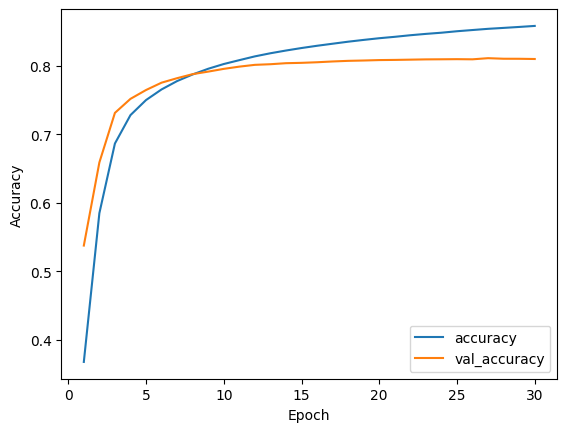

In [30]:
acc=history.history['masked_accuracy']
val_acc=history.history['val_masked_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [31]:
#nog even testen
import numpy as np
import random

def decode_sequence(input_sentence):
    tokenized_input_sentence: list = dutch_tokenizer.encode(input_sentence, out_type=int)
    while len(tokenized_input_sentence) < dutch_maxlen:
        tokenized_input_sentence.append(0)

    # tokenized_input_sentence = np.array(tokenized_input_sentence)

    decoded_sentence: list = frisian_tokenizer.encode(START_TOKEN, out_type=int)
    print("DECODED", decoded_sentence)
    indices = []

    for i in range(frisian_maxlen):
        tokenized_target_sentence = decoded_sentence.copy()

        if len(tokenized_target_sentence) >= frisian_maxlen:
            print(f"{len(tokenized_target_sentence)} is meer dan {frisian_maxlen}")
            break

        while len(tokenized_target_sentence) < frisian_maxlen:
            tokenized_target_sentence.append(0)

        # tokenized_target_sentence = np.array(tokenized_target_sentence)

        # print(tokenized_input_sentence.shape)
        # print(tokenized_target_sentence.shape)

        # inp=np.array(tokenized_input_sentence, tokenized_target_sentence)
        inp=[tf.constant([tokenized_input_sentence]), tf.constant([tokenized_target_sentence])]

        predictions = model(inp)

        # Pak altijd de laatste voorspelling
        sampled_token_index = np.argmax(predictions[0, i, :])
        indices.append(sampled_token_index)

        # sampled_token = fy_index_lookup[sampled_token_index]
        # sampled_token = decode_frisian([sampled_token_index])
        # decoded_sentence += " " + sampled_token

        # if sampled_token == END_TOKEN:
        #     break
        decoded_sentence.append(int(sampled_token_index))

    return frisian_tokenizer.decode_ids(decoded_sentence)

test_dutch_texts = [pair[0] for pair in test_pairs.values]
for _ in range(5):
    input_sentence = random.choice(test_dutch_texts)
    print("-----------------------------------------------------------")
    print("NL:", input_sentence)
    print("FY:", decode_sequence(input_sentence))


-----------------------------------------------------------
NL: ik ging naar de vrouwenarts hij onderzocht me en zei dat ik in de menopauze zat
DECODED [4, 8, 3972]
50 is meer dan 50
FY: [BOS]BOS] ik gie ik gie nei under nei dets de frouljusiid frouljush seiochtocht datsjesje ik siet siet yn [ [ [EOSEOSEOS]]]] [ oan oanEOS [ []]] op [
-----------------------------------------------------------
NL: dood bier
DECODED [4, 8, 3972]
50 is meer dan 50
FY: [BOS]BOS] dea bier in [ [ kEOSEOSoek]]]] [ [ [EOSEOSEOS]]]]] [ [ [EOSEOSEOS]]]] [ [ [EOSEOSEOS]]]] [
-----------------------------------------------------------
NL: vanaf oktober
DECODED [4, 8, 3972]
50 is meer dan 50
FY: [BOS]BOS] sunt oktober sunt [ [ isEOSEOS []]]]] [ [ [EOSEOSEOS]]]]] [ [ [EOSEOSEOS]]]]] [ [ [EOSEOSEOS]]]
-----------------------------------------------------------
NL: de makers beschikten niet over lichtgewicht cameras die in stof vorst of watervrije bekisting hun werk konden doen
DECODED [4, 8, 3972]
50 is meer dan 50


## 5. Evaluation

Tekst

## 6. Deployment

Tekst